In [1]:
from phangs import PhangsGalaxy
import scipy.stats as ss
from astropy.io import fits
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import pandas as pd
import shutil
import os.path
from os import listdir

In [2]:
sources = pd.read_csv('/home/machado.35/projects/intro/scripts/sources.csv')
sources = list(sources['sources'])
fp = '/data/tycho/leroy.42/reduction/alma/phangs-alma/derived/'

res = [60,90,120,150]


cov_masks = listdir('/home/machado.35/projects/masks/coverage/')
for i in range(len(cov_masks)):
    index = cov_masks[i].index('_')
    cov_masks[i] = cov_masks[i][0:index]

In [ ]:
for k in range(len(res)):
    for i in range(len(sources)):
        file = fp+sources[i]+'/'+sources[i]+'_12m+7m+tp_co21_'+str(res[k])+'pc_broad_mom0.fits'
        if os.path.isfile(file):
            ##Generate Radius Map##
            gal = PhangsGalaxy(sources[i])
            #
            hdu = fits.open(file)
            # Build map of radius on the sky
            radius = gal.radius(header=hdu[0].header).to(u.kpc).value
            # Calculate mean in 0.5 kpc bins
            mn, center, _ = ss.binned_statistic(radius.ravel(), np.nan_to_num(hdu[0].data).ravel(),bins=np.arange(0,20,0.5), statistic='mean')
            # Calculate centres of bins
            rmid = (center[0:-1] + center[1:]) * 0.5
            # Generate an interpolation function
            f = interp1d(rmid, mn, bounds_error=False)
            # Evaluate that function for the radius map
            azav = f(radius)
            
            ##Get PHANGS Table Data##
            tab_fp = '/home/machado.35/projects/intro/phangs_sample_table_v1p6.fits'
            tab = fits.open(tab_fp)
            dist  = tab[1].data.dist[111]*u.Mpc
            np.where(tab[1].data.name == 'ngc6300')
            l_sl = tab[1].data.size_scalelength[111]
            #convert scale length from arcsec to kpc
            scale_len = (l_sl/206265)*dist
            sl = scale_len.to(u.kpc)/u.kpc #needs to be unitless
            I_CO = np.exp(-radius/sl)
            hdu[0].data = I_CO
            hdr = hdu[0].header
            hdr['BUNIT'] = ''
            hdr['COMMENT'] = 'Exponential Mask'
            maskhdu = fits.PrimaryHDU(I_CO.value, header=hdr)
            maskhdu.writeto('/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits', overwrite=True)
        
        

In [36]:
for k in range(len(res)):
    for i in range(len(sources)):
        file = '/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits'
        if os.path.isfile(file):
            exp_hdu = fits.open(file)
            exp_data = exp_hdu[0].data
            cov_file = '/home/machado.35/projects/masks/coverage/'+sources[i]+'_12m+7m+tp_co21_'+str(res[k])+'pc_coverage2d.fits'
            cov_hdu = fits.open(cov_file)
            cov_data = cov_hdu[0].data
            ###IMPRINT 2D COVERAGE FOOTPRINT ON EXPONENTIAL MASK
            exp_data[np.where(cov_data == 0)] = 0
            hdr = exp_hdu[0].header
            maskhdu = fits.PrimaryHDU(exp_data, header=hdr)
            maskhdu.writeto('/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits', overwrite=True)


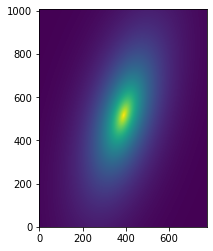

In [28]:
i = 32
k = 0
file = '/home/machado.35/projects/masks/exp/'+sources[i]+'_'+str(res[k])+'pc_exp_mask.fits'
hdu = fits.open(file)
data = hdu[0].data
plt.imshow(data, origin='lower')

In [29]:
data.shape

(1007, 775)

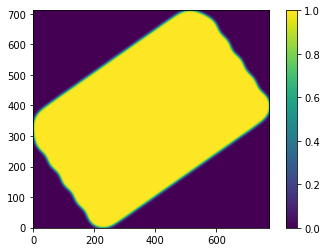

In [43]:
file1 = '/home/machado.35/projects/masks/coverage/ngc6300_12m+7m+tp_co21_150pc_coverage2d.fits'
hdu1 = fits.open(file1)
data1 = hdu1[0].data
plt.imshow(data1, origin='lower')
plt.colorbar()

In [21]:
data1.shape

(1007, 775)

In [33]:
data[np.where(data1 == 0)] = 0

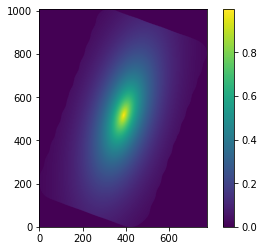

In [34]:
import matplotlib.pyplot as plt
plt.imshow(data, origin='lower')
plt.colorbar()

In [35]:
data.writeto('test.fits')

AttributeError: 'numpy.ndarray' object has no attribute 'writeto'